# MASC General Setup

In [6]:
%load_ext autoreload
%autoreload 2


import sys
import os
import pathlib
import json
import argparse
import numpy as np

import torch
import torch.nn as nn
from pprint import pprint
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
font = {'size'   : 22}
matplotlib.rc('font', **font)

dir_list = str(pathlib.Path().resolve()).split("/")
parent_idx = np.where(np.array(dir_list) == "masc")[0][0]
parent_path = pathlib.Path().resolve()
for idx in range(len(dir_list) - parent_idx - 1):
    parent_path = parent_path.parent
sys.path.append(str(parent_path) + "/")

from masc import misc
from masc.rl import agents
from masc.mpc import controller, models, control_utils
from masc.rl.runner import FullRunner
from masc.rl.rl_utils import ReplayBuffer, Network, DoubleNetwork


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup DoubleIntegrator Environment

In [7]:
# parameters
path2core = str(misc.path2parent("core", str(pathlib.Path)))

config_path = path2core + "/configs/"
model_path = path2core + "/agent_models/"
savelog_path = path2core + "/agent_logs/"

# load config files
agent_config_name = "ddpg_config"
with open(config_path + agent_config_name + ".json", "r") as f:
    agent_config = json.loads(f.read())

env_config_name = "environment_config"
with open(config_path + env_config_name + ".json", "r") as f:
    env_config = json.loads(f.read())

pprint(agent_config)

{'batch_size': 64,
 'delay': 1,
 'gamma': 0.99,
 'learning_rate': 0.0002,
 'lr_decay': 1,
 'lr_decay_step': 100,
 'mue': 0,
 'noise_decay': True,
 'noise_decay_rate': 0.9947,
 'noise_end': 0.02,
 'noise_start': 0.2,
 'tau': 0.005,
 'warm_up': 20000}


In [8]:
seed = 506
# rnd_state = np.random.RandomState(int(seed))


In [9]:
# state space parameters
a = [0, 0, 1]
tau = 0.05

obs_limits, act_limits = np.array([25, 5]), np.array([1])
# define init limits that achieve feasibility from start
init_limits = obs_limits * 0.60
# state space model of double integrator
state_space = control_utils.get_state_space(a, obs_limits, act_limits, tau)
A_d, B_d, C_d, D_d, Mx, wx, Mu, wu, Q, R, S = state_space

# state, action dimensions
n, m = B_d.shape

In [10]:
# set up environment
double_integrator = models.DoubleIntegrator(
    model=(A_d, B_d),
    model_type='exact',
    obs_limits=obs_limits,
    act_limits=act_limits,
    init_limits=init_limits,
    ref_init=np.zeros(n),
    gamma=agent_config['gamma'],
    N=n, M=m,
    seed=int(seed),
    tau=tau,
    **env_config
)

## Configure Function Approximator Networks and Setup DDPG Agent

In [11]:
buffer_size = int(agent_config['warm_up'])
actor_layer = [16, 32, 16]
critic_layer = [16, 32, 16]

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Using cuda device


In [12]:
in_dim = double_integrator.observation_space.shape[0]
out_dim = double_integrator.action_space.shape[0]

# one fead forward network with clipped output
actor = Network(
    [in_dim] + actor_layer + [out_dim],
    activation=nn.LeakyReLU,
    output_activation=nn.Identity,
    clipping=True,
    limit=double_integrator.action_space.high,
)

# two fead forward networks for two critic output
critic = DoubleNetwork(
    [in_dim+out_dim] + critic_layer + [1],
    activation=nn.LeakyReLU,
)

In [13]:
entries = ("obs", "action", "next_obs", "reward", "done", "error", "step")
buffer = ReplayBuffer(buffer_size, entries)

agent = agents.DDPGAgent(
    double_integrator,
    actor_model=actor,
    actor_target_model=actor,
    critic_model=critic,
    critic_target_model=critic,
    **agent_config
)

## Initialize Safeguard

The safeguard can be initialized with given constraints from prior model-knowledge. For this the feasible-set can be calulated with the next cell. If no model is avaiable the safeeguard is initialized with ```feasible_set = None``` and determines the set from estimated modelparamters.

In [14]:
# convergence threshold for feasible set calculation
feasible_convergence_slack = 0.1

# calculate feasible set from prior knowledge
# feasible_set = control_utils.calc_feasible_set(
#    A_d, B_d, Q, R, Mx, wx, Mu, wu,
#    project_dim=[1, 2, 3],
#    N_max=200,
#    N_start=20,
#    discount=0.8,
#    tol=feasible_convergence_slack,
#    notebook_bar=True,
#)

feasible_set = None


In [15]:
safeguard = controller.Safeguard(
    constraints=feasible_set,
)

# safeguard = None


## Initialize Model-Identification Algorithm


In [16]:
# rls forgetting factor
lmbda = 0.9

# only setup model identification if no prior feasible set is available
if feasible_set is None:
    model_id = models.RLSFit(n, m, mu=lmbda)
else:
    model_id = None


## Setup Control Loop Runner

The Runner is used to handle the agent-environment interaction and control loop. If the safeguard and model_id module are defined as ```None``` then the Runner handles a standard RL controller defined by ```agent```

In [17]:
safeguard_penalty = -0.0025

In [18]:
# setup keys for logger
log_keys = [
    'cumulated-reward',
    'episode-length',
    'states',
    'actions',
    'safeguard',
    'reward'
]

In [21]:
observer_episodes = 100
train_episodes = 550
test_episodes = 20
episode_len = 1000

full_runner = FullRunner(
    double_integrator,
    agent,
    buffer,
    safeguard=safeguard,
    state_space_mats=(Mx, wx, Mu, wu, Q, R),
    model_delta=0.001,
    guard_update_steps=2500,
    feasible_set_Nmax=200,
    feasible_set_slack=feasible_convergence_slack,
    safeguard_penalty=safeguard_penalty,
    model_fit=model_id,
    log_keys=log_keys,
    notebook_mode=True,
    seed=seed
)

Control interactions are split up in ```observe```, ```train``` and ```test```. The ```observe``` method can be used to only collect observation to fill the replay buffer without training the agent.

In [22]:
# run rl training
# full_runner.observe(episodes=observer_episodes, max_len=episode_len, max_total_steps=10000)
full_runner.train(episodes=train_episodes, max_len=episode_len)
full_runner.test(episodes=test_episodes, max_len=episode_len, visualize=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


 18%|██▍          | 37.0/200 [00:18<00:04, 35.24it/s, volume difference: 40.137]


Feasible-Set found



  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
# obs_log = None
train_log = full_runner.train_log.get_log(dtype='dict')
test_log = full_runner.test_log.get_log(dtype='dict')

In [24]:
train_df = pd.DataFrame(train_log)
test_df = pd.DataFrame(test_log)

train_df.head()

,cumulated-reward,episode-length,states,actions,safeguard,reward
0,-0.877926,1000,"[[14.800285474661617, -1.687977367501508], [14...","[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1.0...",257,"[-0.0025, -0.0025, -0.0025, -0.0025, -0.0025, ..."
1,-0.626895,1000,"[[1.2884040220964401, -0.2417878826338713], [1...","[[-0.38833803], [-0.114099674], [-0.107115895]...",165,"[-5.1448709019266705e-05, -5.148076822021867e-..."
2,-0.699926,1000,"[[0.7795934821030066, 0.29772384533920304], [0...","[[-0.47974876], [-0.3101299], [-0.09065677], [...",203,"[-3.943521848683453e-05, -3.8766433994549e-05,..."
3,-1.815134,1000,"[[14.65339910728014, -0.7911836452597107], [14...","[[-0.34643668], [0.07310215], [-0.027387187], ...",683,"[-0.0004436027632823157, -0.000442281082155388..."
4,-1.275360,1000,"[[4.90003165510247, 1.780005187180154], [4.989...","[[-0.24238077], [-0.32338274], [-0.36420876], ...",438,"[-0.0002508999276374474, -0.000252179166718308..."


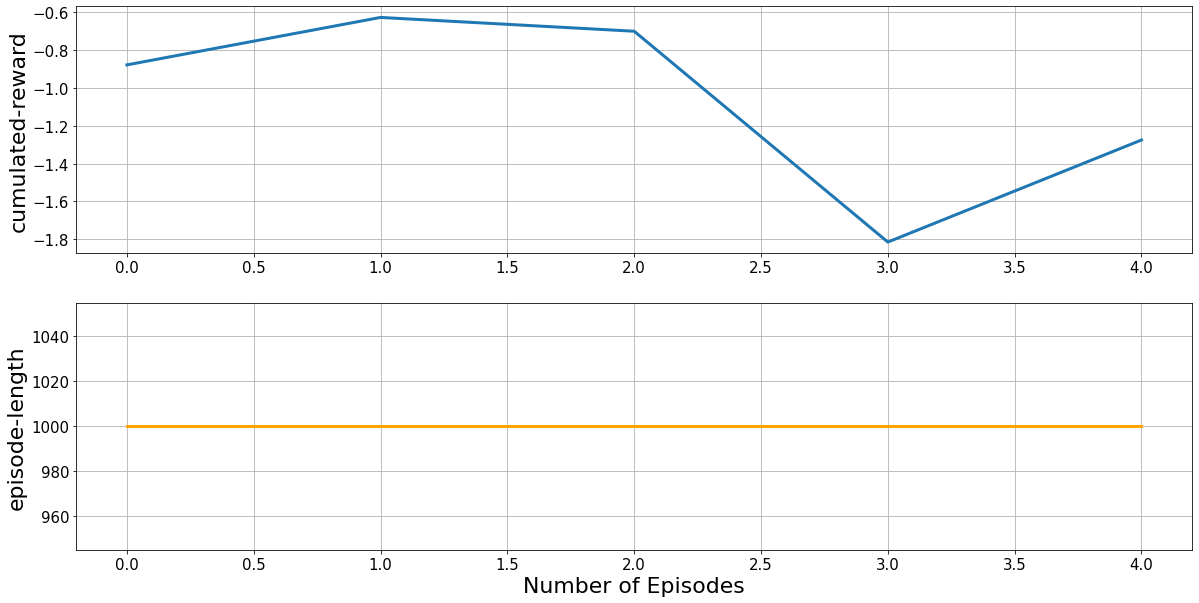

In [25]:
keys = ['cumulated-reward', 'episode-length']

fig, axis = plt.subplots(2, 1, figsize=(20, 10))
axis[0].plot(
    range(len(train_df)), 
    np.asarray(train_df[keys[0]]), 
    linewidth=3
)

axis[1].plot(
    range(len(train_df)), 
    np.asarray(train_df[keys[1]]), 
    linewidth=3,
    c='orange'
)


for idx, ax in enumerate(axis):
    ax.set_ylabel(keys[idx])
    ax.grid(True)
    
axis[-1].set_xlabel('Number of Episodes')
plt.show()